# 9-2. 프로젝트 1: Image Classification

### 라이브러리 불러오기

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

from keras.applications.vgg16 import VGG16
from keras import models
from keras import layers
from keras.layers import Dense, Input,  Flatten
from keras.models import Model

### 데이터 준비

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [3]:
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')
print(train_dir)
print(validation_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation


In [4]:
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats') 
print(train_cats_dir)

# directory with our training dog pictures 
train_dogs_dir = os.path.join(train_dir, 'dogs')  
print(train_dogs_dir)

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  
print(validation_cats_dir)

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  
print(validation_dogs_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/train/dogs
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/dogs


In [5]:
num_cats_tr = len(os.listdir(train_cats_dir))
print('total training cat images:', num_cats_tr)
num_dogs_tr = len(os.listdir(train_dogs_dir))
print('total training dog images:', num_dogs_tr)

print("--")

num_cats_val = len(os.listdir(validation_cats_dir))
print('total validation cat images:', num_cats_val)
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('total validation dog images:', num_dogs_val)

print("--")

total_train = num_cats_tr + num_dogs_tr
print("Total training images:", total_train)
total_val = num_cats_val + num_dogs_val
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
--
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


### 파라미터 설정

In [6]:
# parameter Initialization
batch_size = 16 #배치를 32 이상으로 하면 커널이 자주 죽는다
epochs = 60
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [7]:
# 데이터를 시각화하기 위한 함수
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

### Data Augmentation

In [8]:
# Training data generator
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.5,
                                     width_shift_range=0.3,
                                     height_shift_range=0.3,
                                     zoom_range=0.4,
                                     horizontal_flip=True, 
                                     vertical_flip=False)

In [9]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


In [10]:
train_data_gen[0][0].shape

(16, 256, 256, 3)

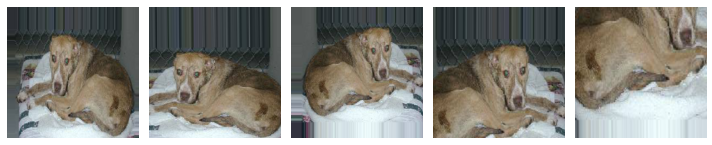

In [11]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [12]:
# Validation data generator
image_gen_val = ImageDataGenerator(rescale=1./255)

In [13]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


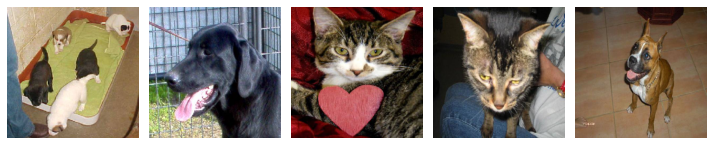

In [14]:
sample_training_images, _ = next(val_data_gen)
plotImages(sample_training_images[:5])

In [15]:
_[:5] # 정답 데이터

array([1., 1., 0., 0., 1.], dtype=float32)

In [16]:
# VGGNet = VGG16(include_top = False)
# VGGNet.summary()

# input_layer=tf.keras.layers.Input(shape=(256, 256, 3))
# x=VGGNet(input_layer)
# x=Flatten()(x)
# x=Dense(1024, activation='relu')(x)
# x=Dense(512, activation='relu')(x)
# out_layer=Dense(1, activation='softmax')(x)
# model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
# model.summary()

pre-trained model을 불러와서 실험해봤으나 커널이 자꾸 죽는 관계로 사용할 수 없었다.

### 1-1. VGG16 모델 구현하기

In [17]:
# 모델
input_layer=tf.keras.layers.Input(shape=(256, 256, 3))
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=layers.Activation('relu')(x)
x=layers.Dropout(0.5)(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=layers.Activation('relu')(x)
x=layers.Dropout(0.5)(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=layers.Activation('relu')(x)
x=layers.Dropout(0.5)(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=layers.Activation('relu')(x)
x=layers.Dropout(0.5)(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=layers.Activation('relu')(x)
x=layers.Dropout(0.5)(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(1024, activation='relu')(x)
x=tf.keras.layers.Dense(512, activation='relu')(x)
x=layers.Dropout(0.5)(x)
out_layer=tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 256, 256, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0     

In [18]:
loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.RMSprop(learning_rate=0.0001)
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

# callbacks_list= [tf.keras.callbacks.TensorBoard(log_dir='log_dir', histogram_freq=1)]
# callback 함수를 활용하고 싶다면 추가해서 학습하는 데에 활용해 보세요.

In [19]:
history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
#       callbacks=callbacks_list,
      validation_freq=1)

Epoch 1/60
125/125 [==============================] - 80s 400ms/step - loss: 1.9712 - binary_accuracy: 0.5105 - val_loss: 0.6963 - val_binary_accuracy: 0.5000
Epoch 2/60
125/125 [==============================] - 47s 376ms/step - loss: 1.0951 - binary_accuracy: 0.4925 - val_loss: 0.6932 - val_binary_accuracy: 0.4560
Epoch 3/60
125/125 [==============================] - 47s 378ms/step - loss: 0.9908 - binary_accuracy: 0.5135 - val_loss: 0.6980 - val_binary_accuracy: 0.5000
Epoch 4/60
125/125 [==============================] - 48s 384ms/step - loss: 0.9086 - binary_accuracy: 0.5130 - val_loss: 0.6936 - val_binary_accuracy: 0.5000
Epoch 5/60
125/125 [==============================] - 48s 385ms/step - loss: 0.9058 - binary_accuracy: 0.5065 - val_loss: 0.6934 - val_binary_accuracy: 0.4980
Epoch 6/60
125/125 [==============================] - 51s 409ms/step - loss: 0.8147 - binary_accuracy: 0.5095 - val_loss: 0.6933 - val_binary_accuracy: 0.5010
Epoch 7/60
125/125 [==========================

#### 드롭 아웃 적용 전

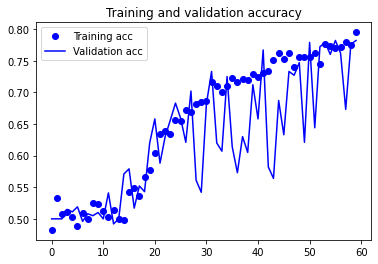

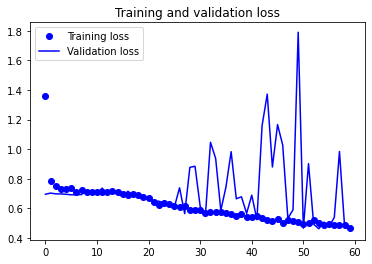

#### epoch 25 쯤에서 과대적합이 일어나기 시작한다고 판단했다. dropout을 적용해보기로 했다.

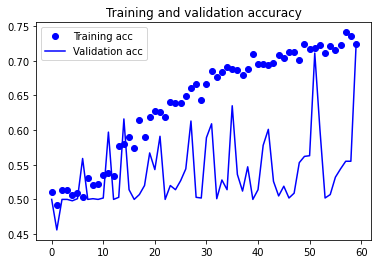

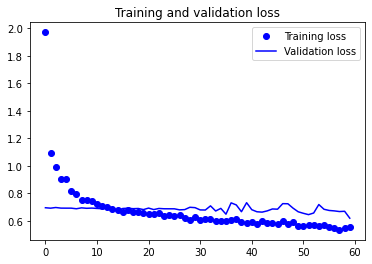

In [20]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### 드롭아웃 적용 후

#### epoch 15쯤부터 과대적합이 일어나기 시작하는 것 같다. validation loss가 드롭아웃 적용 전에 비해 얌전히 변화하고 있다.

--------------

# 9-3. 프로젝트 2: Object Detection

In [21]:
!pip3 install tensorflow-estimator==2.6.0

In [22]:
# Tensorflow와 Tensoflow Hub에 있는 이미 학습된 모델을 활용하기 위한 모듈 
import tensorflow as tf
import tensorflow_hub as hub

# 이미지를 다운로드하는 데에 사용하는 모듈
import matplotlib.pyplot as plt
import tempfile 
from six.moves.urllib.request import urlopen
from six import BytesIO

# 이미지에 선과 폰트를 넣기 위한 모듈
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# Detection하는 데에 소요된 시간을 점검하기 위한 모듈
import time

In [23]:
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)

In [24]:
def download_and_resize_image(url, new_width=256, new_height=256, display=False): 
  
    _, filename = tempfile.mkstemp(suffix=".jpg")
    response = urlopen(url)
    image_data = response.read()
    image_data = BytesIO(image_data)  # 이미지 읽기
    pil_image = Image.open(image_data)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS) # 이미지 조정
    pil_image_rgb = pil_image.convert("RGB") #RBG로 변환
    pil_image_rgb.save(filename, format="JPEG", quality=90) # 이미지 저장
    print("Image downloaded to %s." % filename)
    if display:
        display_image(pil_image)
    return filename

In [25]:
def draw_bounding_box_on_image(image, 
                               ymin, xmin, ymax, xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)

# BBox 테두리 그리기
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

In [26]:
# BBox 그리기
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1): 
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

# BBox 그리기 적용
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])  # 박스 좌표값
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

Image downloaded to /tmp/tmpznzncxm5.jpg.


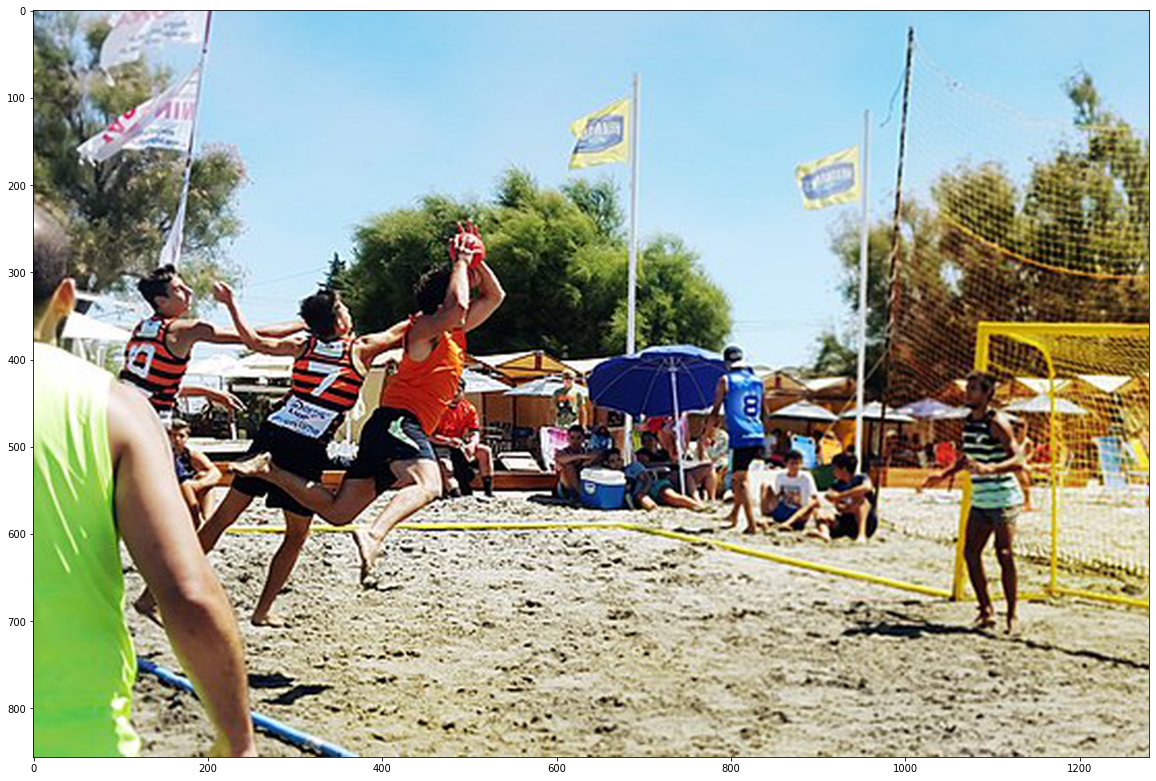

In [27]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Torneo_beach_handball.jpg/640px-Torneo_beach_handball.jpg"
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)  # new_width와 new_height를 변경해 보세요.

In [28]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"  

detector = hub.load(module_handle).signatures['default'] # detector에 사용할 모듈 저장

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [29]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [30]:
def run_detector(detector, path):
  img = load_img(path) 

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

# 소요시간 측정
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

# 이미지 추론 개수와 추론 시간 출력
  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

# 이미지 내 박스로 entity, scores를 추가하여 출력
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

Found 100 objects.
Inference time:  40.56304407119751


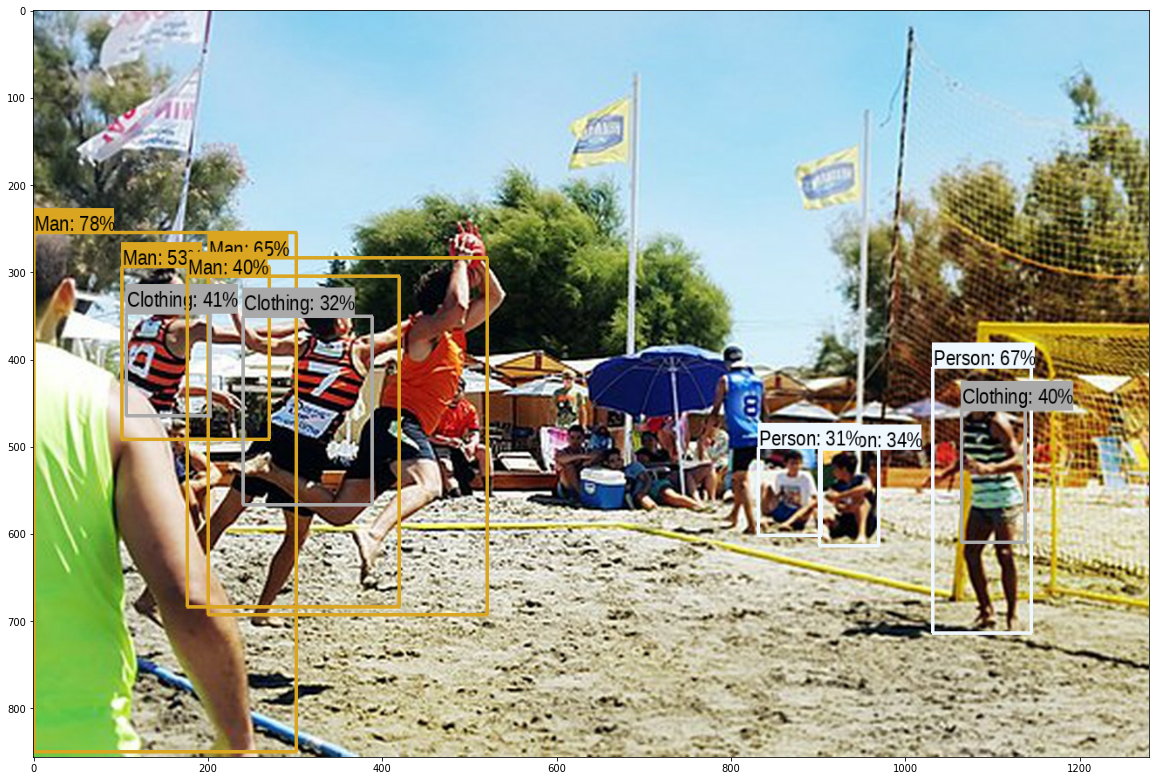

In [31]:
run_detector(detector, downloaded_image_path)

Image downloaded to /tmp/tmpd024e5d7.jpg.


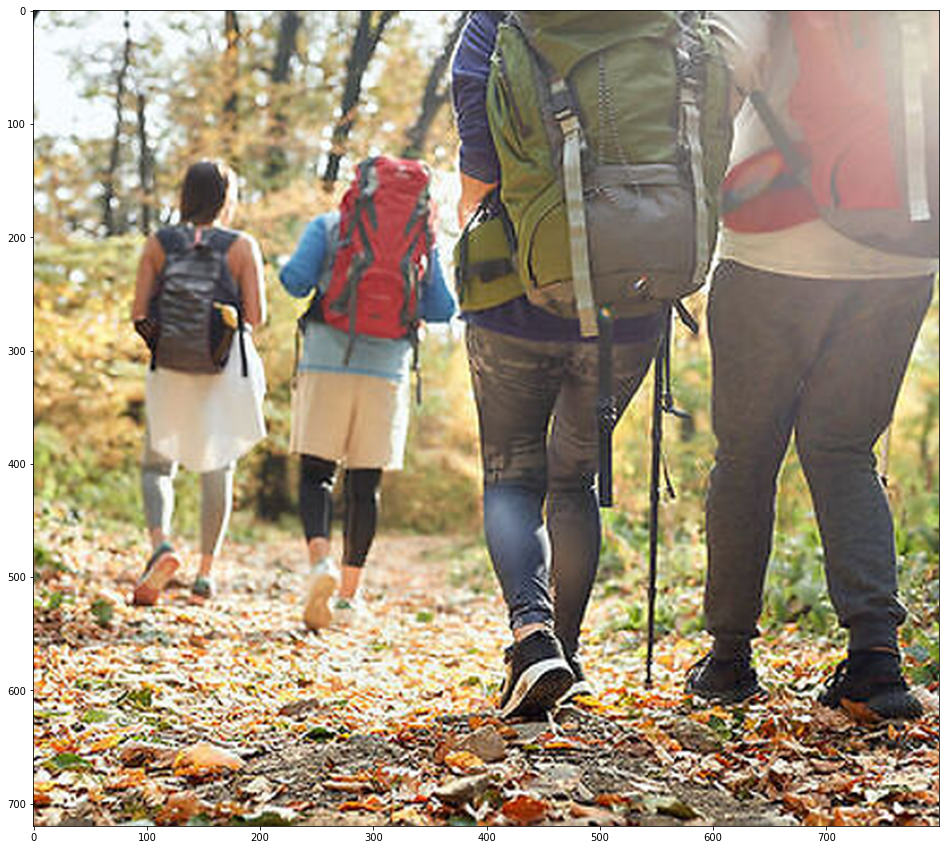

In [32]:
image_url = 'https://src.hidoc.co.kr/image/lib/2022/2/11/1644569794564_0.jpg'
downloaded_image_path = download_and_resize_image(image_url, 800, 720, True)  # new_width와 new_height를 변경해 보세요.

Found 100 objects.
Inference time:  2.8612301349639893


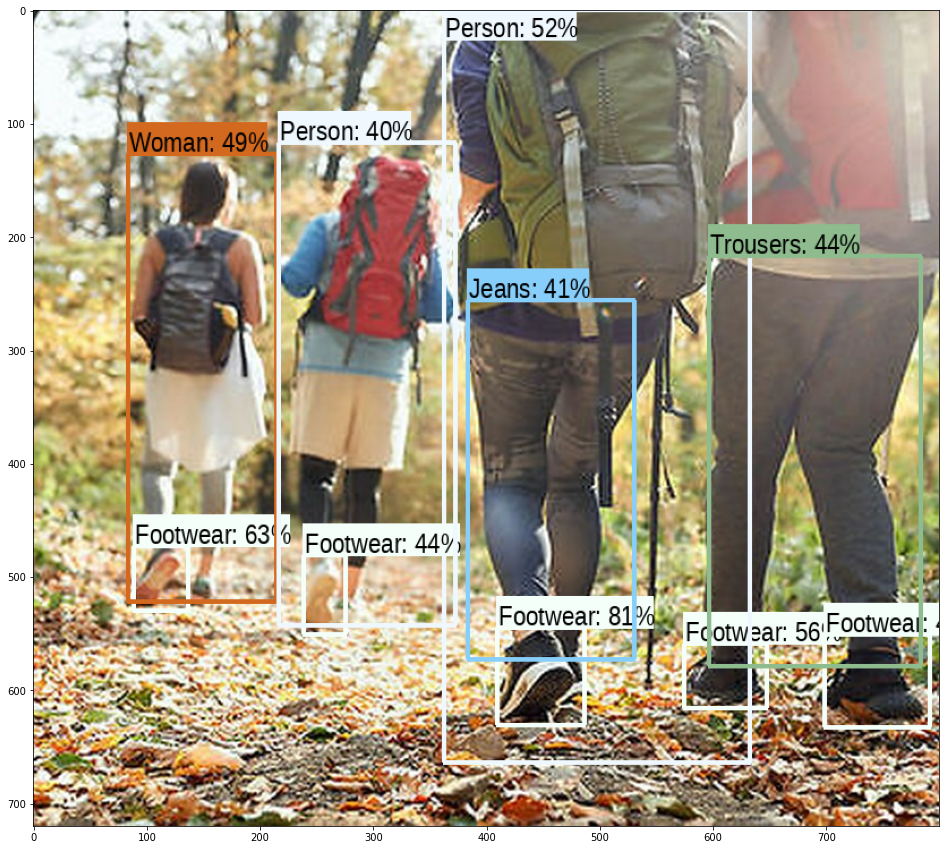

In [33]:
run_detector(detector, downloaded_image_path)

In [34]:
module_handle =  'https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1'

In [35]:
detector = hub.load(module_handle).signatures['default'] # detector에 사용할 모듈 저장

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Found 100 objects.
Inference time:  6.520142078399658


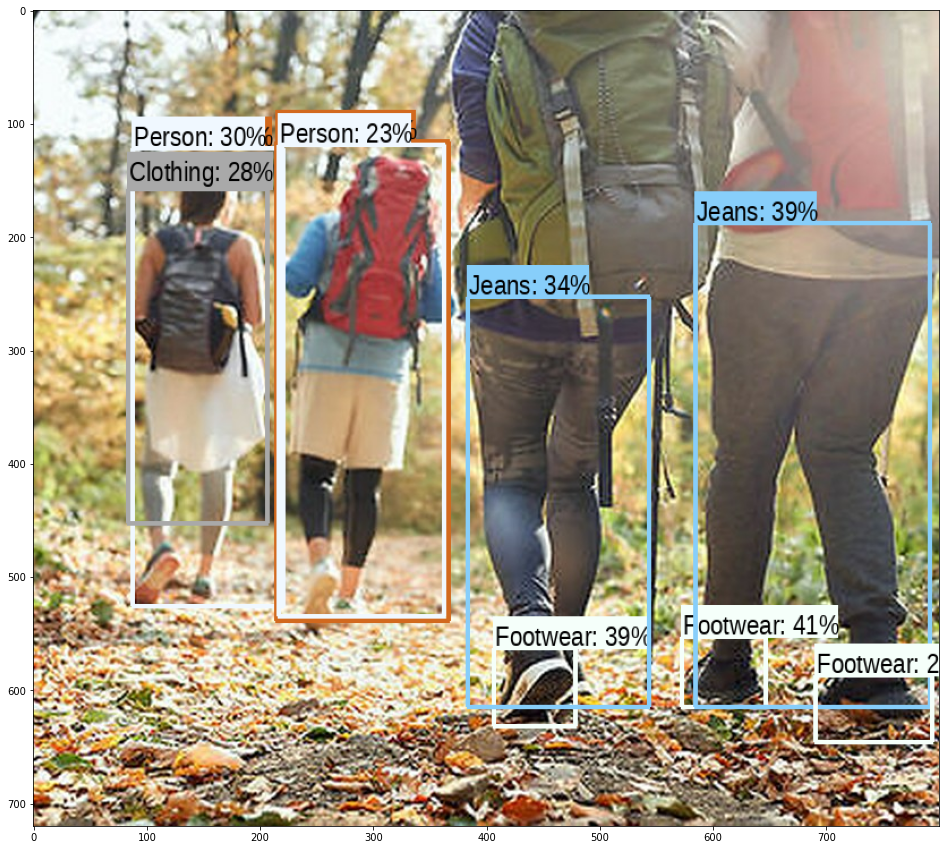

In [36]:
run_detector(detector, downloaded_image_path)

1번째 모델인 Inception ResNet을 사용한 Faster RCNN은 조금 느리지만 높은 정확성을 보였습니다.
  
2번째 모델인 https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1은 정확성도 낮고 분류의 다양성도 낮습니다.

### 회고

##### 어려웠던 점, 해결을 위해 시도한 방법, 문제해결에 성공 또는 실패한 이유

모델이 학습이 안 돼서 어려웠다. 학습시키기 위해 러닝레이트를 많이 줄이는 방식으로 조절했다. 커널이 자꾸 죽고 oom 에러로 학습 과정이 많이 힘들었고, 코랩으로 넘어가서 진행하는 방식으로도 해봤으나 거기서는 렘이 부족해서 진행이 어려웠다. 학습 자체에 시간이 많이 걸려서 힘들었다.

##### 알아낸 점 & 모호한 점

paparspace graident라는 코랩 상위호환 환경을 알아냈다. 아직 러닝레이트를 어느정도로 조정해야 학습이 시작되는 지 잘 모르겠다. 데이터의 크기에 따라 다른 것 같은데, 우선 러닝레이트가 작으면 epoch을 크게 하면 된다는 건 알겠지만 epoch을 크게 하면 커널이 죽으니까 고민이 된다.

모델 레이어를 쌓을 때 functional model 방식으로 처음 쌓아봤다. 뒤에 레이어 이름을 (x) 붙이는 걸 잊어버려서 오류가 자주 났다.

이진분류문제에서는 sigmoid 함수를 적용해야 한다.

__HTTPError: HTTP Error 403: Forbidden__
  
 
urlopen 과정에서 오류가 발생한다. 헤더 네임을 같이 써주면 오류가 나지 않는다.
https://ddolcat.tistory.com/748

모듈에 따라 불러와서 사용하는 방식이 다른 것 같다. 되는 모듈이 있고 안 되는 모듈이 있다.

##### 시도한 내용

러닝레이트 줄이기, 드롭아웃 적용해보기, data augmentation 값 바꿔보기, optimizer를 rmsprop으로 사용해보기, batchsize 변경, epoch 변경

##### 자기 다짐, 프로젝트를 진행하면서 느낀점

케창딥을 이 프로젝트를 진행하기 전에 먼저 따라해봤으면 훨씬 쉬웠을 것 같다.